# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #1:
  1. Install LangGraph
  2. Understanding States and Nodes
  3. Building a Basic Graph
  4. Implementing a Simple RAG Graph
  5. Extending the Graph with Complex Flows

Let's get started!



# 🤝 Breakout Room #1

## Installing Required Libraries

We'll start by grabbing all of our LangChain related packages!

> NOTE: DO NOT RUN THIS CELL IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU "langgraph>=0.5.0", "langsmith>=0.4.4"

## Set Environment Variables

We'll be leveraging OpenAI's suite of APIs - so we'll set our `OPENAI_API_KEY` `env` variable here!

In [2]:
# import os
# import getpass

# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
import os
import openai
from dotenv import load_dotenv

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOpenAI` instance
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?   

Lilly: Stateful applications use persistent storage to ensure this information is not lost and can be accessed or updated in subsequent interactions.    
"coordinated multi-actor and stateful application" is a system where multiple interacting entities (actors) work together in a synchronized and managed way to achieve common goals, while maintaining and tracking relevant information (state) over time.    

Examples:
To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: list[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [4]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

#### Building a Retriever with LangChain

In order to build our `retrieve` node, we'll first need to build a retriever!

This will involve the following steps: 

1. Ingesting Data
2. Chunking the Data
3. Vectorizing the Data and Storing it in a Vector Database
4. Converting it to a Retriever

##### Retreiver Step 1: Ingesting Data

In today's lesson, we're going to be building a RAG system to answer questions about loan complaints - and we will pull information into our index (vectorized chunks stored in our vector store) through LangChain's [`CSVLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.csv_loader.CSVLoader.html)!

> NOTE: We'll be using an async loader during our document ingesting - but our Jupyter Kernel is already running in an asyc loop! This means we'll want the ability to *nest* async loops. 

In [65]:
import nest_asyncio

nest_asyncio.apply()

Now, we're good to load our documents through the [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

In [66]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

In [67]:
loan_knowledge_resources[0].page_content[:1000]

'Volume 3\nAcademic Calendars, Cost of Attendance, and\nPackaging\nIntroduction\nThis volume of the Federal Student Aid (FSA) Handbook discusses the academic calendar, payment period, and\ndisbursement requirements for awarding aid under the Title IV student financial aid programs, determining a student9s\ncost of attendance, and packaging Title IV aid.\nThroughout this volume of the Handbook, the words "we," "our," and "us" refer to the United States Department of\nEducation (the Department). The word "you" refers to the primary audience of the Handbook, school financial aid\nadministrators. In other volumes of the Handbook we use "institution," "school," and "college" interchangeably, unless a\nmore specific meaning is provided. In this volume we consistently use the term "school." <HEA= refers to the Higher\nEducation Act of 1965, as amended. Title IV refers to the student financial aid programs authorized under Title IV of the\nHEA.\nWe appreciate any comments that you have on this

#### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 1000 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [68]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [69]:
!ls ./data

Academic_Calenders_Cost_of_Attendance_and_Packaging.pdf
Applications_and_Verification_Guide.pdf
The_Direct_Loan_Program.pdf
The_Federal_Pell_Grant_Program.pdf


In [70]:
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

### 
Document(page_content=chunks[0].page_content, metadata={"source": "document1.pdf"})
When adding your documents, include metadata:  
```python
from langchain.schema import Document

docs = [
    Document(page_content="Chunk text here", metadata={"source": "document1.pdf"}), 
    Document(page_content="Another chunk", metadata={"source": "document2.pdf"}),
]
vector_store.add_documents(docs)
```  
"Chunk text here" refers to which chunk I need to query: e.g. chunks[0].page_content   
Then, even with one collection, you can filter or inspect metadata["source"].   
each loan_knowledge_chunks[i].page_content 

##### 🏗️ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.  
`YOUR IDEA HERE`  
   1. [Paragraph embeddings] →
   1. [Compute pairwise distance] →
   1. [Identify big jumps] →
   1. [Set threshold using percentile or SD or IQR] →
   1. [Split document at those points] <br> 
<!-- reset list --> <!-- This is a comment -->
i.e.:
1. Use PyMuPDF (import fitz) to get **Paragraph** embeddings
1. Calculate semantic similarity score (e.g. cos) between two adgecent paragraphs
1. Identify big jumps in score (e.g. 0,2 -> .8) (How do I dentify that?)
1. Set threshold using percentile:  
   * percentile (e.g., 90th percentile), or
   * Standard Deviation (STD)-based:  thrs = $\mu + k\sigma$ (k=1, or 2)
   * Interquartile Range (IQR) - stat. dispersion, it tells how spread-out the middle 50% of the data is
   * IQR = 3rd quartile (75%) - 1st Quartile (24%) $IQR = Q_3 - Q_1$
    in semantic similarity as in :         
blocks = [A, B, C, D, E, F] ➡️ ($\longrightarrow$) [A + B], [C + D + E], [F]
1. Split documents at those points
  
`YOUR IDEA HERE`  
`YOUR IDEA HERE`Some overlap to connect each paragraph's conext to the adgecent ones?

#### Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using OpenAI's `text-embedding-3-small` model as our embedding model today!

Let's load it up through LangChain.

In [71]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")


##### ❓ Question #1:

What is the embedding dimension, given that we're using `text-embedding-3-small`?

##### ⚡Answer #1: 1536

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

> HINT: Check out the docs to help you answer this question.

In [72]:
embedding_dim =  1536

#### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

> "Hierarchical Navigable Small World" HNSW Algorithm is used in Qdrant, Milvus, [Weaviate](https://weaviate.io/blog/vector-library-vs-vector-database). Pinecone uses a proprietaty HNSW-like structure.
> Hierarchical means it is structed in layers moving from top to bottom in mevel of detail. 

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here.](https://weaviate.io/blog/vector-library-vs-vector-database)

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [73]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# client = QdrantClient(":memory:")

In [74]:
# === CONFIG ===
use_cloud = False  # Change to True to use cloud 
collection_name ="loan_knowledge_index"

In [75]:
if use_cloud:
    client = QdrantClient(
        url="https://AIE7.cloud.qdrant.io",
        api_key=os.getenv("QDRANT_API_KEY")
    )
else:
    client = QdrantClient(":memory:")

print(f"✅ Client ready: {'Cloud' if use_cloud else 'In-memory'}")


✅ Client ready: In-memory


In [76]:
existing_collections = [col.name for col in client.get_collections().collections]

if collection_name not in existing_collections:
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
    )

print(f"Number of collections = {len([col.name for col in client.get_collections().collections])}")

Number of collections = 1


In case we need more than one collection, we need to create different vector stores for different collection names. But normally we use one collection from all the documents together.
e.g.
```python
vector_store_proj1 = Qdrant(
    client=client,
    collection_name="project1_vectors",
    embeddings=embeddings,
)

vector_store_proj2 = Qdrant(
    client=client,
    collection_name="project2_vectors",
    embeddings=embeddings,
)
```

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [77]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embedding_model,
)

Now that we have our vector database set-up, we can add our documents into it!

In [78]:
count = client.count(collection_name=collection_name).count
print(count)
print(vector_store.client.count(collection_name=vector_store.collection_name))

0
count=0


In [80]:
if count == 0:
    _ = vector_store.add_documents(documents=loan_knowledge_chunks)
else:
    print("✅ Collection already populated, skipping.")


#### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [81]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [82]:
retriever.invoke("What is the loan repayment period?")

[Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 25, '_id': 'ce56b2651b5648fda3f94244bf0856c8', '_collection_name': 'loan_knowledge_index'}, page_content='hour, or non-SE9W nonstandard term program is offered in modules, the minimum loan period is still the lesser of the\nacademic year or the program length (or remaining portion of the program).\nFor Title IV aid purposes, students are allowed to skip one or more modules. However, if a loan period includes modules\nthat the student does not attend, the COA for the loan period may not include costs associated with those mod

#### Creating the Node

We're finally ready to create our node!

In [84]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Generate Node

Next, let's create our `generate` node - which will leverage LangChain and something called an "LCEL Chain" which you can read more about [here](https://python.langchain.com/docs/concepts/lcel/)!    

#### (L) IMPERATIVE <span>&emsp;</span> vs <span>&emsp;</span> DECLARATIVE LCEL FLOW (R)

<!--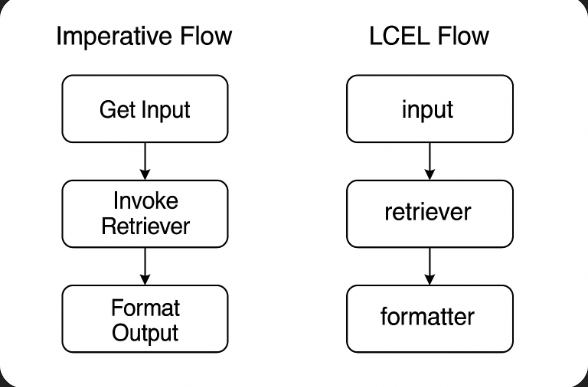

<!--!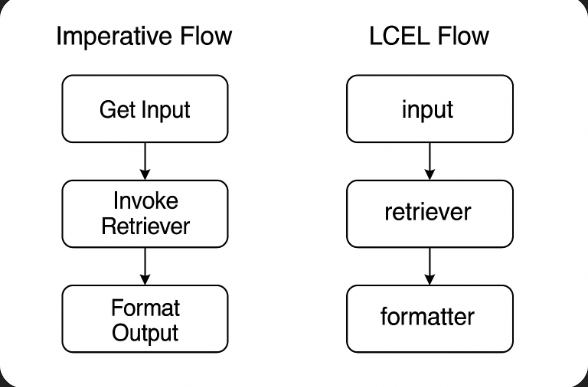
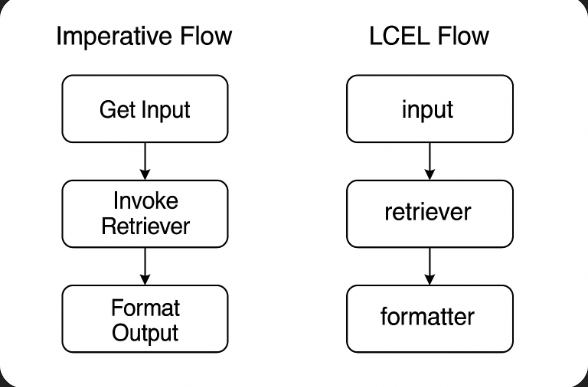
-->
<!--<img src="attachment:.97ce3869-8181-4ab2-8b53-4777a08e4f72.png" style="width:45%; display:inline-block; margin-right:2%;" />-->
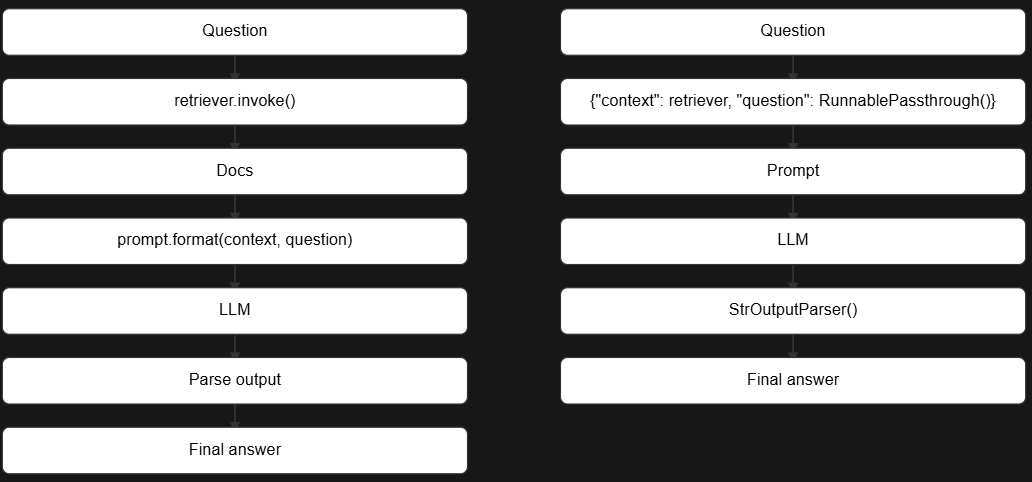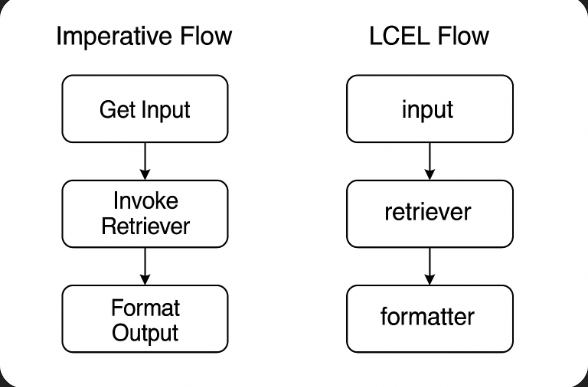

<!--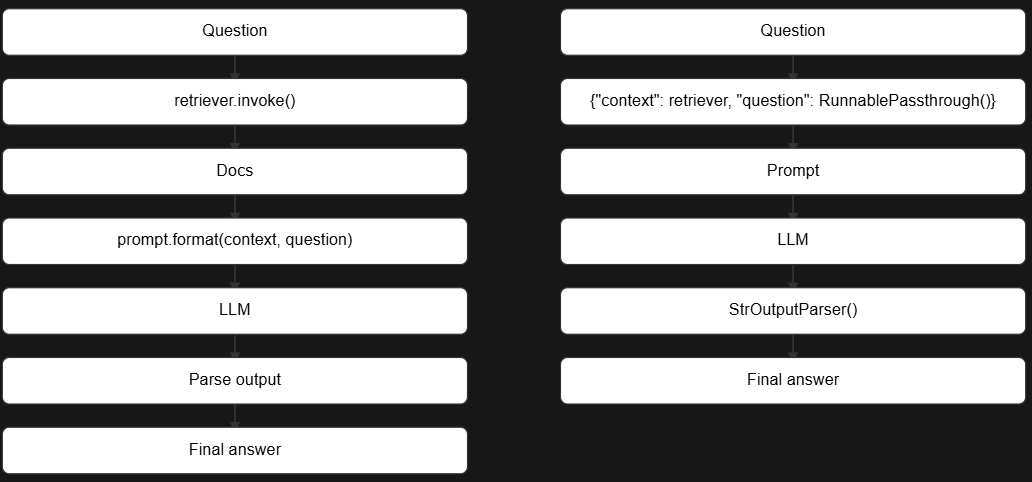
<!--![image](https://chatgpt.com/s/m_686c79f12c548191b28364dc1792b93b) -->

We'll want to create a chain that does the following: 

1. Formats our inputs into a chat template suitable for RAG
2. Takes that chat template and sends it to an LLM
3. Parses that output into `str` format

Let's get chaining!

In [87]:
!pwd

/home/olb/AIE7-BC/AIM_AIE7/04_Production_RAG


#### Chain Components: RAG Chat Template

We'll create a chat template that takes in some query and formats it as a RAG prompt using LangChain's prompt template!

In [89]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [90]:
chat_prompt.invoke({"context" : "OUR CONTEXT HERE", "query" : "OUR QUERY HERE"}).messages[0].content

'\n#CONTEXT:\nOUR CONTEXT HERE\n\nQUERY:\nOUR QUERY HERE\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know"\n'

##### Chain Components: Generator

We'll next set-up the generator - which will be OpenAI's `gpt-41-nano` for today!   
Released April 14, 2025 as part of the GPT‑4.1 family openai.com, with 
context window: 1 million tokens  
Marketed as OpenAI’s "smallest, fastest, and cheapest" GPT‑4.1 model   
Optimized for tasks requiring low latency and smaller compute resources.

In [92]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

Let's now call our model with a formatted prompt.

Notice that we have some nested calls here - we'll see that this is made easier by LCEL.

In [95]:
openai_chat_model.invoke(chat_prompt.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"}))

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 72, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_f12167b370', 'id': 'chatcmpl-BqtJhnXOULTRvhhsnpk0HHxWKQcgk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a5191e51-c912-4197-91b0-cbe7d5f4d351-0', usage_metadata={'input_tokens': 72, 'output_tokens': 7, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### Chain Components: `str` Parser

Finally, let's set-up our `StrOutputParser()` which will transform our model's output into a simple `str` to be provided to the user.

> NOTE: You can see us leveraging LCEL in the example below to avoid needing to do nested calls.

In [97]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | openai_chat_model | StrOutputParser()

generator_chain.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"})

'The capital of France is Paris.'

### `generate` Node: 

Now we can create our `generate` Node!

In [98]:
def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [99]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, they will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [100]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

Next, let's connect our START node to our `retrieve` node by adding an edge.

In [101]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [102]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

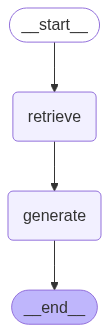

In [103]:
graph

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [118]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})
display(Markdown(response["response"]))

Applying for and securing a student loan in 2025 is not necessarily a terrible idea based on the provided context. The documents describe the process for applying for federal student aid, including deadlines, eligibility verification, counseling, and how loans are packaged and managed. It emphasizes the importance of understanding eligibility requirements, counseling, and careful planning to avoid over- or under-borrowing. While taking a student loan is a significant financial decision, the context does not explicitly state that it is a bad idea to do so in 2025; rather, it provides guidance on how to do it responsibly.

In [107]:
response = graph.invoke({"question" : "How much loan money can I actually get from the government to go to school these days? Is there a cap?"})
display(Markdown(response["response"]))

Based on the provided context, the amount of loan money you can receive from the government depends on your enrollment status, program length, and grade level. 

For example, a dependent first-year undergraduate student enrolled in a 900 clock-hour program with an annual loan limit of $5,500 (not more than $3,500 subsidized) can receive up to that amount, paid in disbursements. If the program is shorter than an academic year or if you complete fewer hours, the loan amounts can be prorated based on the hours completed or the program length.

Additionally, there are aggregate loan limits: for dependents, the maximum combined subsidized and unsubsidized loan debt is $31,000; for independent undergraduates, it is $57,500; and for graduate students, it is $138,500. These limits include previous loans received and cap the total amount you can borrow over time.

In summary, there are caps on both the annual loan amount and total loan debt you can accrue, which vary according to your student status and program specifics.

In [108]:
response = graph.invoke({"question" : "What grants and scholarships are available for free?"})
display(Markdown(response["response"]))

Based on the provided context, grants and scholarships that are available for free include Pell Grants, FSEOG (Federal Supplemental Educational Opportunity Grants), and state grants.

In [109]:
response = graph.invoke({"question" : "Who is Batman?"})
display(Markdown(response["response"]))

I don't know

#### ❓ Question #2:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
- What if the response needs fact-checking?
Consider how you would modify the graph to handle these scenarios.

##### ⚡Answer #2
If the retriever finds no relevant answer:  
Add a node to check if the retriever found a relevant answer: Use a "conditional_edge".  
From the check node to the final result we add two conditional edges:
* If empty, leads to end node with Return "I don't know"
* If there is context, it lead to rhe node generate, which leads to the end node with generated output based on text.

If the response needs fact-checking?
Add yet another fact_checking node after the generate node with a conditional edge:
* Create cyclic graph using a stop criterion e.g., number of cycles.
* use either the same LLM and ask it to self-ask a question to itself compare its result with the context, or add a smaller LLM to do the comparison to the text.
* end at the stop criterion with answering the query.

In [115]:
from IPython.display import display, HTML

mermaid_html = """
<div class="mermaid">
flowchart TD
    Start[Start]
    Retrieve[Retrieve]
    CheckContext[Check Context]
    Generate[Generate]
    FactCheck[Fact Check]
    End[End]

    Start --> Retrieve
    Retrieve --> CheckContext
    CheckContext --> Generate
    Generate --> FactCheck

    FactCheck -->|pass| End
    FactCheck -->|fail| Generate
</div>
"""

display(HTML(mermaid_html))


In [ ]:
from langgraph.graph import StateGraph, START
from typing import TypedDict, List, Optional

# -------------------------
# Define State structure
# -------------------------

class State(TypedDict):
    question: str
    documents: Optional[List[str]]
    response: Optional[str]
    verdict: Optional[str]
    attempts: int

# -------------------------
# Define nodes
# -------------------------

# def retrieve(state):
#     # Dummy simulated retrieval
#     state["documents"] = ["PDF snippet 1", "PDF snippet 2"]
#     return state
graph_builder = graph_builder.add_sequence([retrieve, generate])
def check_context(state):
    if not state.get("documents"):
        state["response"] = "I don't know (no context found)"
        state["stop"] = True
    return state

def generate(state):
    context = " ".join(state["documents"])
    question = state["question"]
    state["response"] = f"Answering: {question}\nUsing context: {context}"
    return state

def fact_check(state):
    # Dummy simulated verdict
    if "edge case" in state["question"].lower():
        state["verdict"] = "No"
    else:
        state["verdict"] = "Yes"
    return state

def end(state):
    return state

# -------------------------
# Build graph
# -------------------------

graph = StateGraph(State)

graph = graph.add_node("retrieve", retrieve)
graph = graph.add_node("check_context", check_context)
graph = graph.add_node("generate", generate)
graph = graph.add_node("fact_check", fact_check)
graph = graph.add_node("end", end)

# Add main sequence
graph = graph.add_edge(START, "retrieve")
graph = graph.add_edge("retrieve", "check_context")

# If context exists, go to generate
graph = graph.add_edge("check_context", "generate")
# If no context, skip to end (check_context sets stop flag)
graph = graph.add_edge("check_context", "end")

graph = graph.add_edge("generate", "fact_check")

# Conditional edges for fact_check
def check_verdict(state):
    attempts = state.get("attempts", 0)
    if "yes" in state.get("verdict", "").lower():
        return "pass"
    else:
        attempts += 1
        state["attempts"] = attempts
        if attempts >= 3:
            state["response"] = "I don't know (max attempts reached)"
            return "pass"
        return "fail"

graph = graph.add_conditional_edges(
    "fact_check",
    check_verdict,
    {
        "pass": "end",
        "fail": "generate"
    }
)

# -------------------------
# Compile and run
# -------------------------

compiled_graph = graph.compile()

state = {
    "question": "How could we extend our current implementation to handle edge cases?",
    "attempts": 0,
}

result = compiled_graph.invoke(state)
print(result["response"])
